# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,2.032515,True,11.517678
1,-0.991765,False,-2.604534
2,2.973576,True,12.653210
3,1.238046,False,4.824492
4,1.053408,True,8.908305
...,...,...,...
995,-0.586416,True,4.211017
996,0.930279,True,7.552883
997,0.855264,False,2.451511
998,0.503639,False,2.937192


<AxesSubplot: xlabel='v0'>

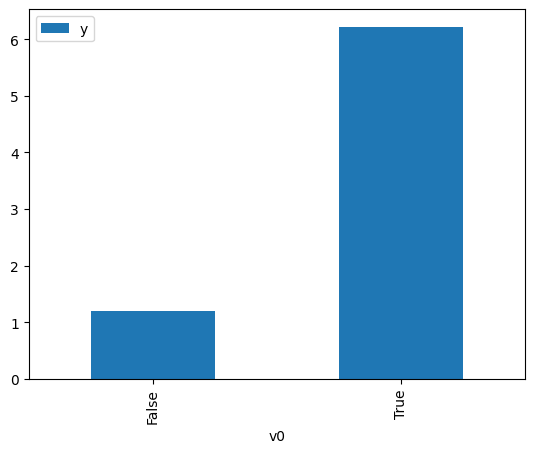

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

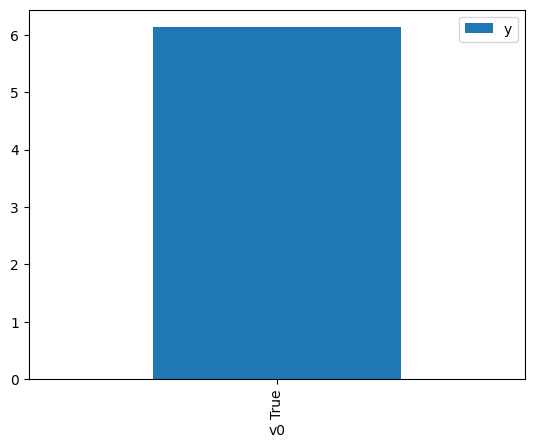

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.320538,False,1.730849,0.411577,2.429678
1,-0.667775,False,-1.854502,0.637296,1.569130
2,1.100085,False,2.840350,0.252754,3.956420
3,1.694506,False,4.973412,0.162741,6.144730
4,0.164330,False,2.302419,0.447231,2.235982
...,...,...,...,...,...
995,0.492115,False,1.172215,0.373470,2.677589
996,1.959409,False,5.301127,0.131832,7.585432
997,0.238855,False,1.247627,0.430130,2.324880
998,-1.235162,False,-4.513237,0.748842,1.335395


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.408195,True,7.635348,0.608055,1.644587
1,0.120814,True,4.158793,0.542723,1.842561
2,0.839406,True,8.148286,0.698682,1.431267
3,-1.326933,True,1.226598,0.235416,4.247792
4,1.085213,True,8.940591,0.744619,1.342968
...,...,...,...,...,...
995,0.808319,True,8.924909,0.692548,1.443944
996,0.359826,True,5.383857,0.597261,1.674310
997,-0.741361,True,2.133050,0.347005,2.881800
998,1.790282,True,10.254748,0.849058,1.177775


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.975
Model:                            OLS   Adj. R-squared (uncentered):              0.975
Method:                 Least Squares   F-statistic:                          1.928e+04
Date:                Mon, 14 Nov 2022   Prob (F-statistic):                        0.00
Time:                        17:33:13   Log-Likelihood:                         -1400.7
No. Observations:                1000   AIC:                                      2805.
Df Residuals:                     998   BIC:                                      2815.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.9734      0.034     87.935      0.000       2.907       3.040
x2             4.9619      0.047    104.885      0.000       4.869       5.055
==============================================================================
Omnibus:                        0.564   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.754   Jarque-Bera (JB):                0.586
Skew:                          -0.057   Prob(JB):                        0.746
Kurtosis:                       2.971   Cond. No.                         1.96
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""